# Homework Assignment 4:
##  Unsupervised Learning
*Due: Wednesday, April 21, 2021*   



Alloted Team : 
- [Prateesh Reddy](https://github.iu.edu/CSCI-P556-Spring-2021/P556-prpatlol/tree/master/hw1)
- [Vakharia Milind](https://github.iu.edu/CSCI-P556-Spring-2021/P556-mivakh/tree/master/hw1) 



### Question 1. 

Using the [MNIST dataset](https://www.kaggle.com/c/digit-recognizer), perform the following 6 Steps:



In [302]:
# Import Libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [303]:
# Lets say if the GPU is available we'll use it otherwise we'll use CPU
# We get few warnings for seaborn packages lets ignore them 
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings('ignore')

In [304]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
X = X/255.0*2 - 1
# X = X/255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

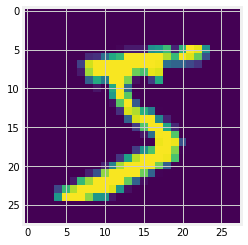

In [305]:
digit = X[0]
digit_pixels = digit.reshape(28, 28)
plt.imshow(digit_pixels)

In [306]:
print("MNIST Dataset Size's:")
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))
print('Y_train: ' + str(y_train.shape))

MNIST Dataset Size's:
X_train: (46900, 784)
X_test: (23100, 784)
Y_train: (46900,)


### Performing Principal Component Analysis (PCA) to reduce the dimensionality of each example beforehand

In [307]:
# Standardizing our data
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X_train)
print('Checking the shape of our standardized data is same or not', standardized_data.shape)

Checking the shape of our standardized data is same or not (46900, 784)


In [308]:
# Computing the co-variance matrix i.e.. X^T * X
sample_data = standardized_data
covar_matrix = np.matmul(sample_data.T , sample_data)
print('The shape of our co-variance matrix =', covar_matrix.shape)

The shape of our co-variance matrix = (784, 784)


In [309]:
# Computing eigenvalues and eigenvectors
# Eigenvectors determine the direction of the new attribute space
# Eigenvalues ​​determine its magnitude. These 2 are required for PCA

values, vectors = eigh(covar_matrix, eigvals=(782, 783))
print('The shape of our co-variance matrix =', vectors.shape)

# Converting the eigen vectors into (2,d) shape where elements in it represent eigen vectors corresponding to its principal eigen vectors i.e.. f1 and f2 
vectors = vectors.T

The shape of our co-variance matrix = (784, 2)


In [310]:
new_coordinates = np.matmul(vectors, standardized_data.T)
print(new_coordinates.shape)
# Appending label to the 2d projected data or vertical stack 
new_coordinates = np.vstack((new_coordinates, y_train)).T

(2, 46900)


In [311]:
# Creating a new data frame for plotting the labeled points where f1 and f2 are 1st and 2nd principles
dataframe = pd.DataFrame(new_coordinates, columns=["f1", "f2", "labels"])
dataframe.head()

,f1,f2,labels
0,-9.08412,3.31542,6
1,-9.92575,-1.25347,3
2,-2.4619,-1.35937,3
3,-6.71344,0.527561,6
4,7.49245,-3.94776,4


In [312]:
from sklearn import decomposition
pca = decomposition.PCA()
# PCA for dimensionality redcution 
pca.n_components = 784
pca_data = pca.fit_transform(sample_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

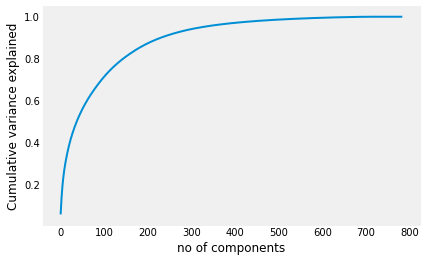

In [313]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('no of components')
plt.ylabel('Cumulative variance explained')
plt.show()

## Q1. Perform K-means clustering using an appropriate value for K, where the clusters are initialized from random data from the dataset. Discuss how you selected the appropriate value for K.

In [314]:
# Lets take dataframe we got after PCA is done and drop labels so that we predict them using kmeans 
sample_train_data = dataframe.drop(['labels'], axis=1)
sample_train_data = np.array(sample_train_data)
print(sample_train_data.shape)

(46900, 2)


In [315]:
# Function to find optimal k with random initialisation 
def findOptimalK():
    distort = list()
    for k in range(1, 30):
        kmeans = KMeans(n_clusters=k, init='random')
        kmeans = kmeans.fit(sample_train_data)
        distort.append(kmeans.inertia_)
        
    return distort

In [316]:
distort = findOptimalK()

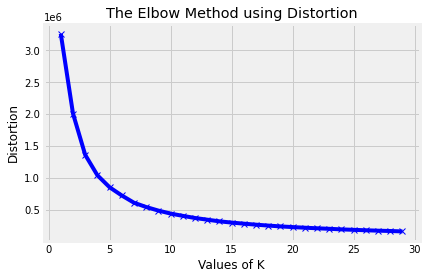

In [317]:
plt.plot(range(1, 30), distort, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


**To determine the optimal number of clusters , we have to select the value of k at the “elbow” i.e.. the point after which the distortion or inertia starts decreasing in a linear fashion. Thus for the MNIST data with random initialisation for kmeans the optimal number of clusters is 10** 

In [344]:
kmeans = KMeans(n_clusters=10, init='random', n_init=10, max_iter=300)
#predict the labels of clusters.
label = kmeans.fit_predict(sample_train_data)
# centroids = kmeans.cluster_centers_
print("Centroids shape : no of centroids: {}, dimension of our centroids: {}".format(centroids.shape[0], centroids.shape[1]))
print(label)
print(kmeans.labels_)

Centroids shape : no of centroids: 10, dimension of our centroids: 2
[8 4 1 ... 8 1 8]
[8 4 1 ... 8 1 8]


In [345]:
# Lets pick 10 random colors to display for our clusters of digits
from random import randint
color = []
for i in range(10):
    color.append('#%06X' % randint(0, 0xFFFFFF))
color

['#48CB2B',
 '#40A3CC',
 '#0ADF71',
 '#956702',
 '#DC7C87',
 '#F42F4D',
 '#87D83F',
 '#F04721',
 '#12D005',
 '#9C35B0']

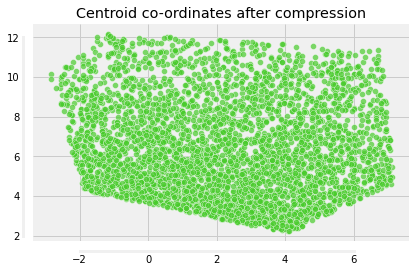

In [346]:
import seaborn as sns
#filter rows of original data
filtered_label0 = sample_train_data[label == 0]
 
#plotting the results
ax = sns.scatterplot(filtered_label0[:,0], filtered_label0[:,1], color = color[0], alpha=0.7, marker = 'o')
ax.set_title('Centroid co-ordinates after compression')
sns.despine(offset=10, trim=True)

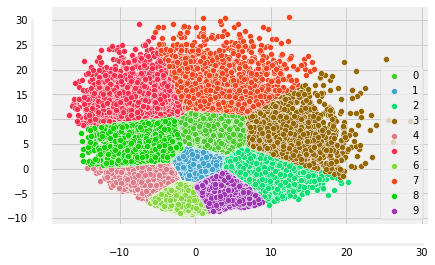

In [347]:
labels = np.unique(label)
for i in labels:
    ax = sns.scatterplot(sample_train_data[label == i, 0], sample_train_data[label == i, 1], label=i, color=color[i])
sns.despine(offset=20, trim=True)

**2) Displaying the cluster centroids for random initialization**

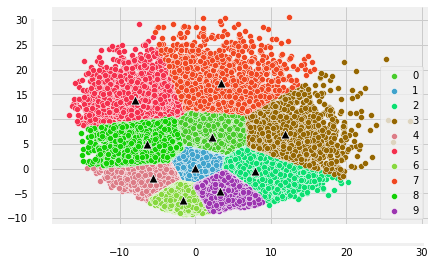

In [348]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
labels = np.unique(label)
 
for i in labels:
    ax = sns.scatterplot(sample_train_data[label == i , 0] , sample_train_data[label == i , 1] , label = i, color=color[i])
ax = sns.scatterplot(centroids[:,0] , centroids[:,1] , s = 80, marker='^', color = 'k')
sns.despine(offset=20, trim=True)

**Relation between Centroids and labels for random initialization**

In above figure, the black triangles are the centroids. The centorids have a good relation with the clusters. The clusters with wide data have a little normalisaed centroids i.e. closer to the middle centroids but overall these represent the data very well. 

### Kmeans++ 

In [323]:
def findOptimalKplus():
    distort_plus = list()
    for k in range(1, 20):
        kmeansplus = KMeans(n_clusters=k)
        kmeansplus = kmeansplus.fit(sample_train_data)
        distort_plus.append(kmeansplus.inertia_)
    return distort_plus
distort = findOptimalKplus()

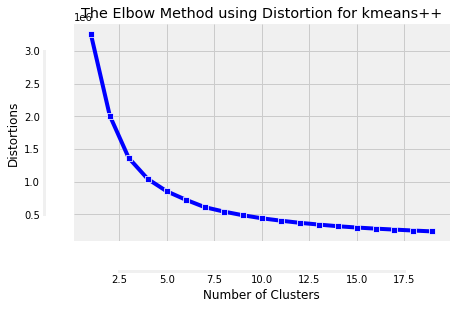

In [324]:
ax = sns.lineplot(range(1, 20), distort, marker = 's', color = "blue")
ax.set(xlabel='Number of Clusters', ylabel='Distortions')
ax.set_title('The Elbow Method using Distortion for kmeans++')
sns.despine(offset=30, trim=True)
# plt.plot(range(1, 20), distort, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion for kmeans++')
# plt.show()

**Similar graph for Kmeans++ as well the graph started becoming more linear once k=10. So, let us take no of clusters as 10**

In [358]:
#Initialize the class object
kmeans_plus = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=300)
#predict the labels of clusters.
label_plus = kmeans_plus.fit_predict(sample_train_data)
# Cluster centroids
centroids_plus = kmeans_plus.cluster_centers_
print("Centroids shape : no of centroids: {}, dimension of our centroids: {}".format(centroids_plus.shape[0], centroids_plus.shape[1]))
print(label_plus)
print(kmeans_plus.labels_) 

Centroids shape : no of centroids: 10, dimension of our centroids: 2
[1 7 3 ... 1 3 1]
[1 7 3 ... 1 3 1]


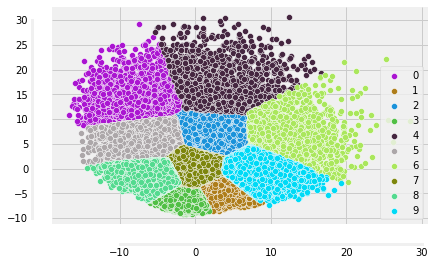

In [326]:
labels_plus = np.unique(label_plus)
for i in labels_plus:
    ax = sns.scatterplot(sample_train_data[label_plus == i, 0], sample_train_data[label_plus == i, 1], label=i, color=color[i])

sns.despine(offset=20, trim=True)

**3) Displaying the cluster centroids for Kmeans++ initialization**

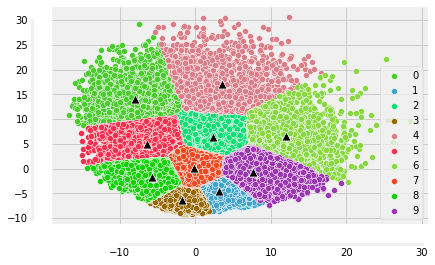

In [357]:
#Getting the Centroids
centroids_plus = kmeans_plus.cluster_centers_
labels_plus = np.unique(label_plus)
 
for i in labels_plus:
    ax = sns.scatterplot(sample_train_data[label_plus == i , 0] , sample_train_data[label_plus == i , 1] , label = i, color=color[i])
ax = sns.scatterplot(centroids_plus[:,0] , centroids_plus[:,1] , s = 80, marker='^', color = 'k')
sns.despine(offset=20, trim=True)

**Relation between Centroids and labels for Kmeans++ initialization**

In above figure, the black triangles are the centroids. Quite similar to the random initialisation.The centorids have a good relation with the clusters. The clusters with wide data have a little normalisaed centroids i.e. closer to the middle centroids but overall these represent the data very well. 

**4) Clustering by using Centroids obtained from taking a single sample of the dataset for each cluster points**

As we assumed that we have label information we pick that from train data. Randomly choose 1 sample from each of the
classes to serve as the initial cluster centers.

In [394]:
train_imag = sample_train_data
train_img = pca_data
train_labels = y_train 
train_labels = np.array(train_labels)

In [395]:
# train_imag[:1]

In [396]:
import random
#  Randomly choose 1 sample from each of the classes to serve as the initial cluster centers
labels_dict = {}
for i, label in enumerate(train_labels):
    if label not in labels_dict:labels_dict[label] = []
    labels_dict[label].append(i)

sampled_label_index = np.zeros((len(labels_dict), train_imag.shape[-1]))
for j, _label in enumerate(labels_dict.keys()):
    rand_index = random.sample(labels_dict[label], k=1)
    sampled_label_index[j] = train_imag[rand_index]

In [397]:
kmeansamp = KMeans(init=sampled_label_index, n_clusters=10, max_iter=300)
#predict the labels of clusters.
labels_samp = kmeansamp.fit_predict(train_imag)
# Cluster centroids
centroids_samp = kmeansamp.cluster_centers_
print("K: {}. The dimension of centroids: {}".format(centroids_samp.shape[0], centroids_samp.shape[1]))
print(labels_samp)
print(centroids_samp.shape)
print(kmeansamp.labels_)   

K: 10. The dimension of centroids: 2
[0 1 2 ... 0 2 0]
(10, 2)
[0 1 2 ... 0 2 0]


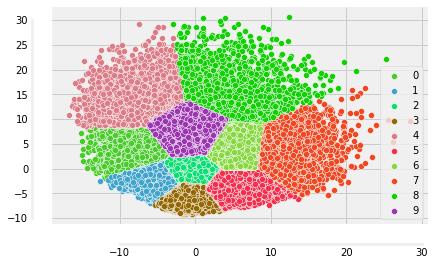

In [398]:
labelsamp = np.unique(labels_samp)
 
for i in labelsamp:
    ax = sns.scatterplot(train_imag[labels_samp == i, 0], train_imag[labels_samp == i, 1], label=i, color=color[i])

sns.despine(offset=20, trim=True)

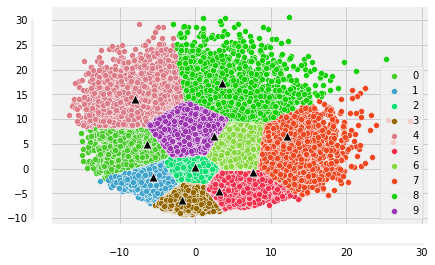

In [399]:

labelsamp = np.unique(labels_samp)
centroids_samp = kmeansamp.cluster_centers_
#plotting the centroids:
 
for i in labelsamp:
    ax = sns.scatterplot(train_imag[labels_samp == i, 0], train_imag[labels_samp == i, 1], label=i, color=color[i])
ax = sns.scatterplot(centroids_plus[:,0] , centroids_plus[:,1] , s = 80, marker='^', color = 'k')
sns.despine(offset=20, trim=True)

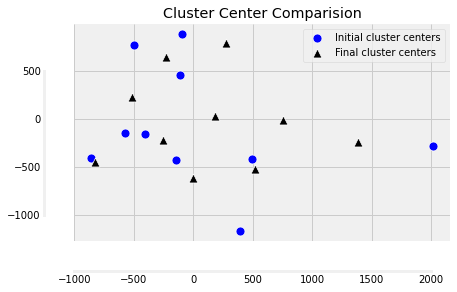

In [363]:
ax = sns.scatterplot(samples[:,0] , samples[:,1] , s = 80, marker='o', color = 'blue',label='Initial cluster centers')
ax = sns.scatterplot(centroids_samp[:,0] , centroids_samp[:,1] , s = 80, marker='^', color = 'black',label='Final cluster centers')
ax.set_title("Cluster Center Comparision")
sns.despine(offset=30, trim=True)

####  Comparing between initial cluster centers to the final cluster centers:
For some centroids, the initial centers are close to the final centers, while some don't. But the for the centers which are not close, they would not go too far away from the initial centers. We can see one such case in the far right which is little bit distanced which has wide cluster data. They still represent the data as we can see similar pacing of clusters.

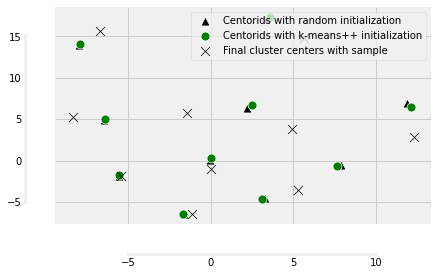

In [360]:
ax = sns.scatterplot(centroids[:,0] , centroids[:,1] , s = 80, marker='^', color = 'k',label='Centorids with random initialization')
ax = sns.scatterplot(centroids_plus[:,0] , centroids_plus[:,1] , s = 80, marker='o', color = 'green',label='Centorids with k-means++ initialization')
ax = sns.scatterplot(centroids_samp[:,0] , centroids_samp[:,1] , s = 80, marker='x', color = 'k',label='Final cluster centers with sample')
sns.despine(offset=30, trim=True)

#### cluster centroids comparision for the above three approaches:
We can see that in most of the cases the centroids are very similar. Comparitively, Centroids with random and kmeans++ initialisation are more closer to each other than the one with sampling labels.

In [400]:
results1 = kmeans.predict(X=sample_train_data_numpy)
results2 = kmeans_plus.predict(X=sample_train_data_numpy)
results3 = kmeans_samp.predict(X=sample_train_data_numpy)
variance1, variance2, variance3 = 0,0,0
for i, label in enumerate(results1):
    variance1 += np.linalg.norm(x=(sample_train_data_numpy[i] - centroids[label]))

for i, label in enumerate(results2):
    variance2 += np.linalg.norm(x=(sample_train_data_numpy[i] - centroids_plus[label]))

for i, label in enumerate(results3):
    variance3 += np.linalg.norm(x=(sample_train_data_numpy[i] - centroids_samp[label]))
print("Variance for Predicted Test with random initialization: {}\nVariance for Test with k-means++ initialization: {}\nVariance for Test with label information: {}".format(variance1, variance2, variance3))

Variance for Predicted Test with random initialization: 13486572.24072477
Variance for Test with k-means++ initialization: 13485046.703178292
Variance for Test with label information: 13701206.196009966


#### Variance comparision for 3 results:

First all it is good that the variance is low. We can see similar variance for all three types of results. However, variance of kmeans++ has least variance but very near to random initialisation. The sampling label variance is highest , this is consistent throught all of our observations so it is understandable.
